In [114]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.io import loadmat
from numpy.random import choice, rand
from numpy.lib import pad
from math import sqrt, floor, ceil

### 1.1 Visualizing the data

In [3]:
def load_data(file):
    return loadmat(file)

In [4]:
data = load_data('./ex4data1.mat')
X = data['X']
# y = np.array(list(map(lambda a: [0] if a[0] == 10 else a, data['y'])))
y = data['y']
print(X.shape)
print(y.shape)

(5000, 400)
(5000, 1)


In [5]:
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array looks like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))


def unblockshaped(arr, h, w):
    """
    Return an array of shape (h, w) where
    h * w = arr.size

    If arr is of shape (n, nrows, ncols), n sublocks of shape (nrows, ncols),
    then the returned array preserves the "physical" layout of the sublocks.
    """
    n, nrows, ncols = arr.shape
    return (arr.reshape(h//nrows, -1, nrows, ncols)
               .swapaxes(1,2)
               .reshape(h, w))

def pad_with_ones(vector, pad_width, iaxis, kwargs):
    vector[:pad_width[0]] = 1
    vector[-pad_width[1]:] = 1
    return vector

def display_data(data):
    imgs = np.array([pad(data[i].reshape(20, 20).T, 1, pad_with_ones) for i in range(len(data))])
    
    m, height, width = imgs.shape
    n_row = floor(sqrt(m))
    n_col = ceil(m/n_row)
    
    imgs = unblockshaped(imgs, n_row*imgs.shape[1], n_col*imgs.shape[2])
    
    plt.gray()
    plt.imshow(imgs)

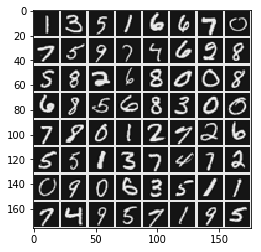

In [6]:
sample_data = X[choice(X.shape[0], 64, replace=False)]
# sample_data = X[0:64]
display_data(sample_data)

### 1.2 Model representation

In [7]:
weights = load_data('./ex4weights.mat')
theta_1 = weights['Theta1']
theta_2 = weights['Theta2']
print(theta_1.shape)
print(theta_2.shape)

(25, 401)
(10, 26)


### 1.3 Feedforward and cost function

In [8]:
def sigmoid(x, derivative=False):
    return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [126]:
def nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lamb):
    # Part 1,3 Feedforward
    m = len(y)
    theta_1 = nn_params[:hidden_layer_size*(input_layer_size+1)].reshape(hidden_layer_size, input_layer_size+1)
    theta_2 = nn_params[hidden_layer_size*(input_layer_size+1):].reshape(num_labels, hidden_layer_size+1)

    a1 = np.c_[np.ones((X.shape[0],1)), X] # 5000*401
    
    z2 = a1.dot(theta_1.T) # 5000*25
    a2 = np.c_[np.ones((X.shape[0],1)), sigmoid(z2)] # 5000*26
    
    z3 = a2.dot(theta_2.T) # 5000*10
    a3 = sigmoid(z3) # 5000*10
    y_matrix = pd.get_dummies(y.ravel()).values # 5000*10
    # Outer product since y_matrix is dummy matrix
    J = -1*(1/m)*np.sum(y_matrix*np.log(a3) + (1-y_matrix)*np.log(1-a3)) + \
        (lamb/(2*m))*(np.sum(np.square(theta_1[:,1:])) + np.sum(np.square(theta_2[:,1:])))
    
    # Part 2 Backpropagation
    d3 = a3 - y_matrix # 5000*10
    d2 = d3.dot(theta_2[:,1:])*sigmoid(z2, True) # 5000*25

    delta_1 = d2.T.dot(a1) # 25*401
    delta_2 = d3.T.dot(a2) # 10*26
    
    theta1_ = np.c_[np.ones((theta_1.shape[0], 1)), theta_1[:,1:]] # 25*401
    theta2_ = np.c_[np.ones((theta_2.shape[0], 1)), theta_2[:,1:]] # 10*26

    theta1_grad = delta_1/m + (lamb/m)*theta1_
    theta2_grad = delta_2/m + (lamb/m)*theta2_
    
    return J, theta1_grad, theta2_grad

In [127]:
nn_params = np.r_[theta_1.flatten(), theta_2.flatten()]
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10

In [131]:
J, theta1_grad, theta2_grad = nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lamb=0)
print(J)

0.2876291651613189


In [132]:
J, theta1_grad, theta2_grad = nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lamb=1)
print(J)

0.38376985909092365


### 2.2 Random initialization

In [118]:
def rand_initialize_weights(l_in, l_out):
    # epsilon_init = np.sqrt(6)/np.sqrt(l_in+l_out)
    epsilon_init = 0.12
    return rand(l_out, 1+l_in)*2*epsilon_init - epsilon_init

In [119]:
theta_1_init = rand_initialize_weights(400,25)
theta_2_init = rand_initialize_weights(25,10)
print(theta_1_init.shape)
print(theta_2_init.shape)

(25, 401)
(10, 26)


### 2.4 Gradient checking (Todo)

In [133]:
def compute_numerical_gradient(J, theta):
    # theta should be unrolled to 1*m vector
    m = len(theta)
    numgrad = np.zeros((m, 1))
    perturb = np.zeros((m, 1))
    e = 1e-4
    for p in range(m):
        # Set perturbation vector
        perturb[p] = e
        loss1 = J(theta - perturb)
        loss2 = J(theta + perturb)
        numgrad[p] = (loss2 - loss1)/(2*e)
        perturb[p] = 0
    
    return numgrad

In [ ]:
def check_nn_gradients(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lamb=1):
    J, theta1_grad, theta2_grad = nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lamb=1)
    grad = np.r_[theta1_grad.flatten(), theta2_grad.flatten()]
    numgrad = compute

### 2.6 Learning parameters

In [ ]:
res = minimize(lr_cost_function, theta, method='BFGS', jac=lr_gradient, args=(X,c_y,lamb), options={'disp': True})